In [13]:
import sys
import os
from pathlib import Path 

# Add project root to path to allow importing src
current_dir = Path.cwd()
if current_dir.name == "notebooks":
    sys.path.append(str(current_dir.parent))
else:
    sys.path.append(str(current_dir))

import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import matplotlib.pyplot as plt
import numpy as np

from src.monotone_grad_nets.models import cmgn, icgn, icnn, mmgn
from src.monotone_grad_nets.trainers import trainer
from src.monotone_grad_nets.utils.verification import *
from src.monotone_grad_nets.utils.plotting import plot_error_maps

device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Trivial Experimentation:
Here we will test our models on the standard problem mentioned in the paper which attempts to estimate the gradient field of $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ over the **unit square** such that:
\begin{equation}
f(x) = x_1^4 + \frac{x_2}{2} +  \frac{x_1 x_2}{2}  + \frac{3x_2^2}{2} -  \frac{x_2^3}{3}
\end{equation}

Its gradient is given by : 

\begin{equation}
\nabla f(x) = g(x_1,x_2) = \begin{pmatrix}4x_1^3 + \frac{1}{2}x_2  \\ 3x_2 - x_2^2 + \frac{1}{2}x_1 + 0.5\end{pmatrix}
\end{equation}

In [3]:
def func(z):
    x1 = z[:,0]
    x2 = z[:,1]
    return torch.stack([x1**4 + 0.5*x2 + 0.5 *x1*x2 + 1.5 * x2**2 - x2**3/3]).T

def gradient(z):
    x1 = z[:,0]
    x2= z[:,1]
    return torch.stack([4*x1**3 + 0.5*x2, 3*x2 - x2**2 + 0.5*x1 + 0.5]).T

### Dataset:

In [4]:
# Generate random samples in the unit square
num_samples = 10000
x = torch.rand(num_samples, 2)  # Shape: [num_samples, 2]

# Compute the true gradient ∇f(x)
true_grad = gradient(x)  # Shape: [num_samples, 2]
true_f = func(x)

dataset = TensorDataset(x, true_grad)
train_loader_grad = DataLoader(dataset, batch_size=32, shuffle=True)

dataset = TensorDataset(x, true_f)
train_loader_f = DataLoader(dataset, batch_size=32, shuffle=True)


### Models:

In [5]:
input_dim = 2
output_dim = 2

# Models suggested by the Ppaer
model_CMGN = cmgn.C_MGN(input_dim=input_dim, hidden_dim=2, num_layers=2, output_dim=output_dim, ortho=True).to(device)

model_MMGN = mmgn.M_MGN(input_dim=input_dim, hidden_dim=3, num_layers=2).to(device)

# Benchmark Models
model_ICGN = icgn.I_CGN(input_dim=input_dim, hidden_dim=5, num_layers=1).to(device)
model_ICNN = icnn.I_CNN(input_dim=input_dim, hidden_dim=1, num_layers=19).to(device)

print("Number of parameters in C-MGN", sum(p.size().numel() for p in model_CMGN.parameters()))
print("Number of parameters in M-MGN", sum(p.size().numel() for p in model_MMGN.parameters()))
print("Number of parameters in I-CGN", sum(p.size().numel() for p in model_ICGN.parameters()))
print("Number of parameters in I-CNN", sum(p.size().numel() for p in model_ICNN.parameters()))

Number of parameters in C-MGN 14
Number of parameters in M-MGN 24
Number of parameters in I-CGN 15
Number of parameters in I-CNN 76


In [6]:
model = cmgn.C_MGN(input_dim=3, hidden_dim=3, output_dim=3, num_layers=2, ortho=True)
print("Number of parameters in M-MGN", sum(p.size().numel() for p in model.parameters()))

Number of parameters in M-MGN 27


### Training and Results:

**MMGN Model:**

Epoch 50 | Train Loss: 0.0115 | Train Cost: 3.3919 | : 100%|██████████| 50/50 [01:16<00:00,  1.54s/it]


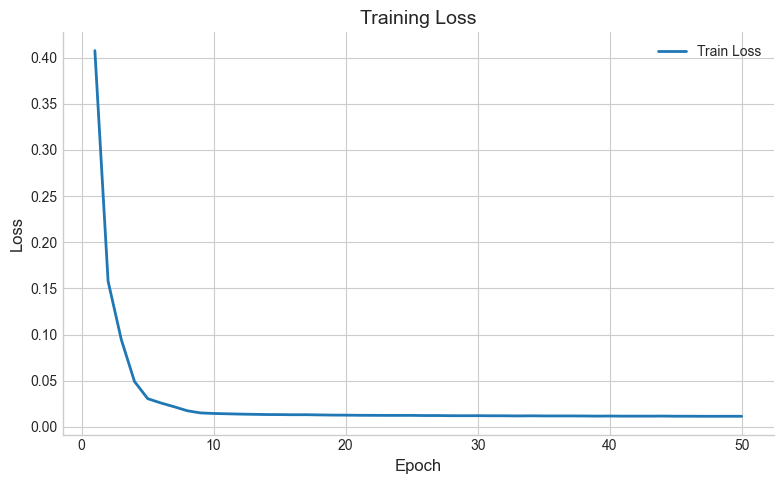

In [7]:
mmgn_trainer = trainer.Trainer(
    dataset='2D_function',
    n_epochs=50,
    model=model_MMGN,
    true_fx=gradient,  # True gradient function
    criterion='L1loss',  # Use L1 loss for gradient approximation
    optimizer='Adam',
    lr=0.001,
    batch_size=32,
    use_amp=True if torch.cuda.is_available() else False,
    accumulation_steps=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

mmgn_trainer.train(train_loader_grad)
mmgn_trainer.plot_train_metrics()

**CMGN Model:**

Epoch 100 | Train Loss: 0.1851 | Train Cost: 2.9310 | : 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


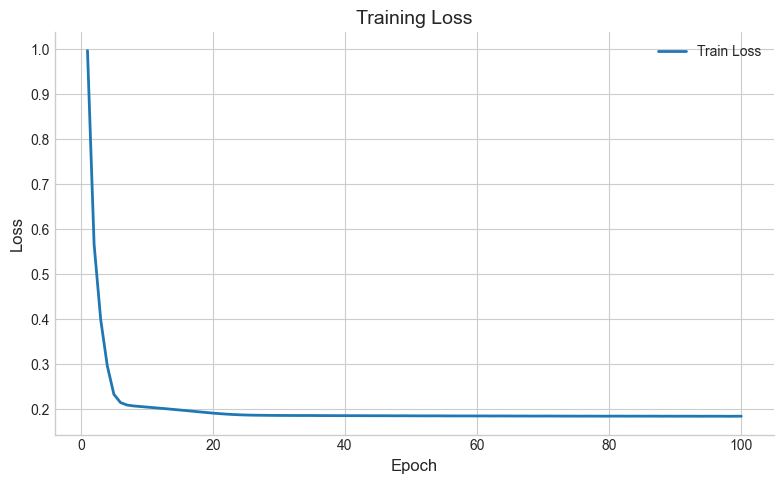

In [8]:
cmgn_trainer = trainer.Trainer(
    dataset='2D_function',
    n_epochs=100,
    model=model_CMGN,
    true_fx=gradient,  # True gradient function
    criterion='L1loss',  # Use L1 loss for gradient approximation
    optimizer='Adam',
    lr=0.001,
    batch_size=32,
    use_amp=True if torch.cuda.is_available() else False,
    accumulation_steps=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

cmgn_trainer.train(train_loader_grad)
cmgn_trainer.plot_train_metrics()

**ICGN Model:**

Epoch 50 | Train Loss: 0.1636 | Train Cost: 2.6985 | : 100%|██████████| 50/50 [01:02<00:00,  1.25s/it]


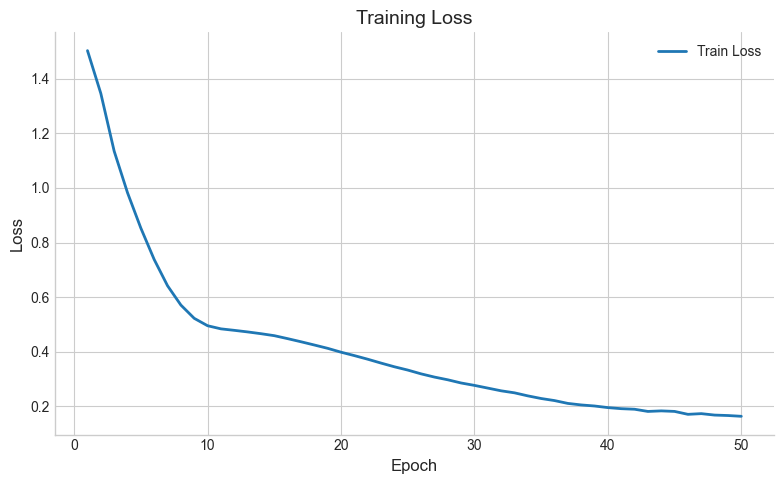

In [9]:
icgn_trainer = trainer.Trainer(
    dataset='2D_function',
    n_epochs=50,
    model=model_ICGN,
    true_fx=gradient,  # True gradient function
    criterion='L1loss',  # Use L1 loss for gradient approximation
    optimizer='Adam',
    lr=0.001,
    batch_size=32,
    use_amp=True if torch.cuda.is_available() else False,
    accumulation_steps=1,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

icgn_trainer.train(train_loader_grad)
icgn_trainer.plot_train_metrics()

**ICNN Model:**

Epoch 50 | Train Loss: 0.0420 | Train Cost: 0.9807 | : 100%|██████████| 50/50 [02:41<00:00,  3.22s/it]


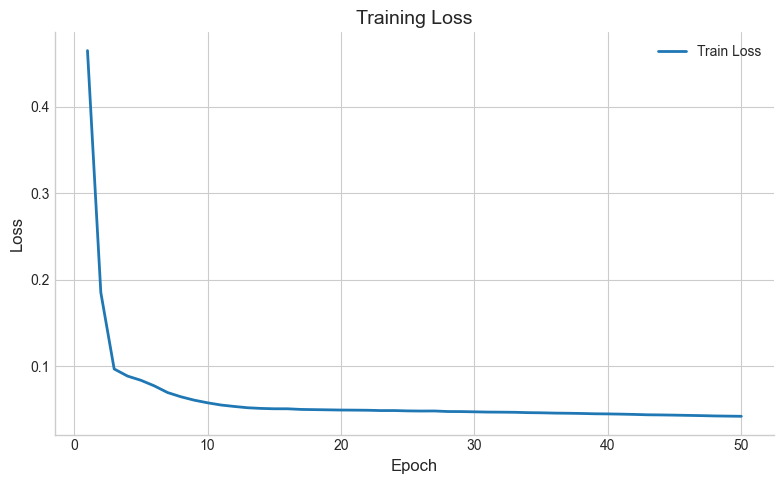

In [10]:
icnn_trainer = trainer.Trainer(
    dataset='2D_function',
    n_epochs=50,
    model=model_ICNN,
    true_fx=func,  # True gradient function
    criterion='L1loss',  # Use L1 loss for gradient approximation
    optimizer='Adam',
    lr=0.001,
    batch_size=32,
    use_amp=True if torch.cuda.is_available() else False,
    accumulation_steps=1,
    device='cuda' if torch.cuda.is_available() else 'cpu',

)
icnn_trainer.train(train_loader_f)
icnn_trainer.plot_train_metrics()

# Models Comparison

### Error Maps Plot:

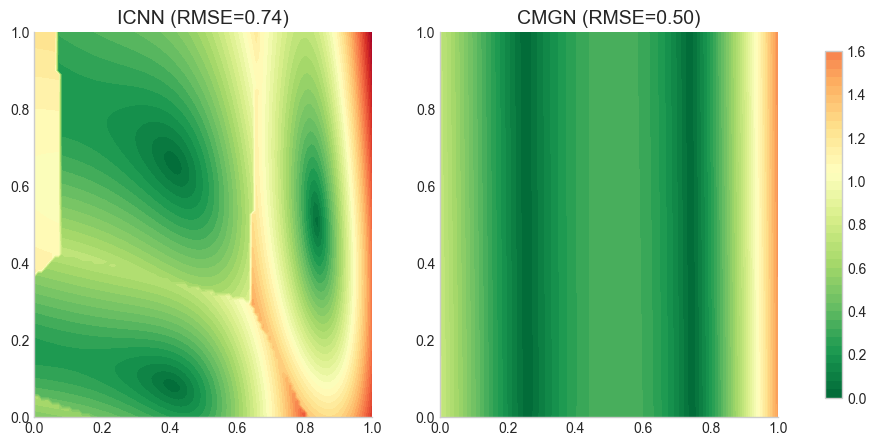

In [14]:
plot_error_maps([icnn_trainer.model,  cmgn_trainer.model], gradient, ['ICNN', 'CMGN'], xi_res=100, yi_res=100)

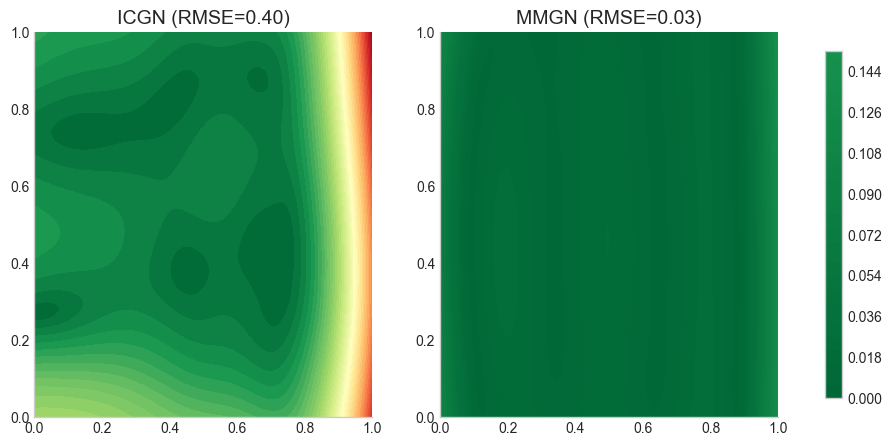

In [15]:
plot_error_maps([icgn_trainer.model, mmgn_trainer.model], gradient, ['ICGN','MMGN'], xi_res=100, yi_res=100)